# 00_quickstart - Training a Unet++ model for building segmentation

This notebook walks you through a **minimal end-to-end run** and gives a *working pipeline* you can adapt to your own data and configs.

1) prepare a small dataset,
2) train **UNet++** (CPU-friendly),
3) run inference / test,
4) visualize predictions.

**What you’ll need**
- Repo installed (editable is fine) and environment from `pyproject.toml` / `environment.yml`
- The small demo archive that is included with the repo and unzipped automatically below
- No GPU required; although you could set one up if wanted.

**Note:** This quickstart uses **direct Python calls to GDL’s core classes** (no config file). A separate notebook will show the **config-driven workflow** with LightningCLI which is the recommended approach for full experiments

### Dataset source and license

For this quickstart example, we use a small subset of the **Waterloo Building Dataset**. This dataset consists of high-resolution aerial orthoimagery and building footprint labels, introduced in the article:

>Hongjie He, Zijian Jiang, Gao, Kyle, Sarah Narges Fatholahi, Weikai Tan, Bingxu Hu, Hongzhang Xu, Michael A Chapman, and Jonathan Li. Waterloo building dataset: A city-scale vector building dataset for mapping building footprints using aerial orthoimagery. Geomatica, 75(3):99–115, 2022d

The dataset is openly available through **Harvard Dataverse**:  
[https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/EXRA2V](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/EXRA2V)

For reproducibility and lightweight demos, we provide a pre-sampled subset (`data/waterloo_subset_512.zip`) included in this repository.

## Imports and environment check

Before running the pipeline, we import the required libraries and verify the environment setup:

- Confirm Python, PyTorch, and Lightning versions  
- Ensure geospatial libraries (e.g., `rasterio`, `geopandas`) are available
- Append root paths to import local module properly

In [1]:
import time
start_total = time.time()

print("Importing required libraries...")

# Core modules
import os, sys, platform, random
import zipfile
import warnings
from pathlib import Path

# Data and ML
import csv
import numpy as np
import torch
import lightning as L
import rasterio as rio
import matplotlib.pyplot as plt

# Remove warnings from not georeferenced dataset (for this example only)
from rasterio.errors import NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

# Append root path to make module work from notebook (might differ in your environment)
sys.path.append("..")

# Environment info
print(f"Imports done in {time.time() - start_total:.2f} seconds\n")

# Print system info
print("\n--- Environment Info ---")
print("Python:", sys.version.split()[0])
print("OS:", platform.platform())
print("Torch:", torch.__version__)
print("Lightning:", L.__version__)
print("Device:", "CUDA" if torch.cuda.is_available() else "CPU")

Importing required libraries...
Imports done in 1.75 seconds


--- Environment Info ---
Python: 3.10.18
OS: Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.39
Torch: 2.4.1.post300
Lightning: 2.5.0.post0
Device: CUDA


## Prepare dataset - Extract .zip data with proper folder structure

The next step will:

1. **Unzip** the demo archive into a folder next to the `.zip` file  
2. **Preview** a sample image–label pair for a quick sanity check  
   
**Note**: In this subset, the images and labels are **already split into 512×512 patches**. In a real workflow, you might start with full-scene imagery and corresponding label rasters/vectors. In that case, you’ll first need to **tile them into smaller chips** (e.g., 256×256 or 512×512) before training. See the [CSVDataset](https://github.com/NRCan/geo-deep-learning/blob/lightning_refactor/geo_deep_learning/datasets/csv_dataset.py#L26-L63) for details on the expected input format.

../data/waterloo_subset_512 already extracted.


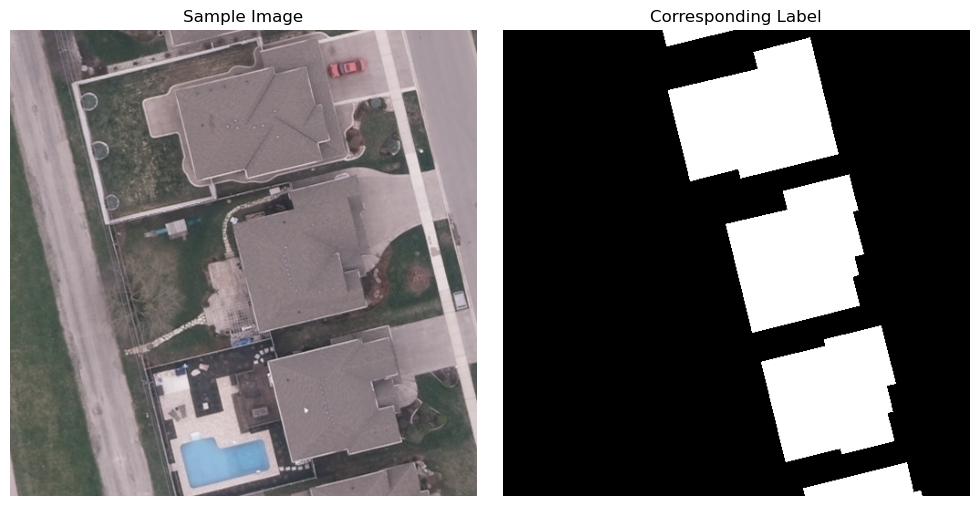

In [2]:
# Define path to the archive and extract location
zip_path = Path("../data/waterloo_subset_512.zip")
extract_dir = zip_path.with_suffix('')  # removes .zip

# Unzip only if not already done
if not extract_dir.exists():
    print(f"Extracting to {extract_dir}...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)
else:
    print(f"{extract_dir} already extracted.")

# Sanity check: print 1 image/label pair from 'trn' split
img_dir = extract_dir / "trn" / "image"
lbl_dir = extract_dir / "trn" / "label"

sample_imgs = sorted(img_dir.glob("*.tif"))
if sample_imgs:
    sample_path = sample_imgs[0]
    label_path = lbl_dir / sample_path.name

    with rio.open(sample_path) as img_ds:
        img = img_ds.read([1, 2, 3])  # RGB
    with rio.open(label_path) as lbl_ds:
        lbl = lbl_ds.read(1)  # single-channel label

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(img.transpose(1, 2, 0).astype("uint8"))
    ax1.set_title("Sample Image")
    ax1.axis("off")

    ax2.imshow(lbl, cmap="gray")
    ax2.set_title("Corresponding Label")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("No images found in trn/image/")

## Remap labels

In this repo, and with the chosen loss function, it is easier if label rasters use a **contiguous set of class IDs starting at 0**.  

The desired class for this example are:
- **0** → background  
- **1** → building footprint  

We’ll remap the label rasters accordingly to ensure they align with the model and loss expectations.

In [3]:
from tqdm import tqdm
import numpy as np
import rasterio as rio

# Remap all labels in the dataset
for split in ["trn", "val", "tst"]:
    lbl_dir = extract_dir / split / "label"
    if not lbl_dir.exists():
        continue

    for lbl_path in tqdm(sorted(lbl_dir.glob("*.tif")), desc=f"Remapping {split} labels"):
        with rio.open(lbl_path) as lbl_ds:
            lbl = lbl_ds.read(1)

            # Remap 255 → 1
            lbl = np.where(lbl == 255, 1, lbl).astype("int16")

            # Save back (overwrite in place)
            profile = lbl_ds.profile
            profile.update(dtype="int16", count=1)

        with rio.open(lbl_path, "w", **profile) as dst:
            dst.write(lbl, 1)

Remapping tst labels: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 357.85it/s]


## Prepare dataset - Create CSV files for each split

Since we will be using the [csv_dataset](https://github.com/NRCan/geo-deep-learning/blob/lightning_refactor/geo_deep_learning/datasets/csv_dataset.py#L26-L63), we need to create a CSV file for each data split that **maps image–label pairs**.

This step will:

1. Create 'trn.csv', 'val.csv', and 'tst.csv' in the root of the extracted dataset folder
2. Each CSV will list the absolute paths to image and label patches, matching the structure expected by [csv_dataset](https://github.com/NRCan/geo-deep-learning/blob/lightning_refactor/geo_deep_learning/datasets/csv_dataset.py#L26-L63)

In [4]:
splits = ["trn", "val", "tst"]

for split in splits:
    img_dir = extract_dir / split / "image"
    lbl_dir = extract_dir / split / "label"
    csv_path = extract_dir / f"{split}.csv"

    # Collect matching image–label pairs
    rows = []
    for img_path in sorted(img_dir.glob("*.tif")):
        lbl_path = lbl_dir / img_path.name
        if lbl_path.exists():
            rows.append([str(img_path.resolve()), str(lbl_path.resolve())])
        else:
            print(f"No matching label found for {img_path.name}")

    # Write CSV
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f, delimiter=";")
        writer.writerows(rows)

    print(f"Wrote {len(rows)} pairs to {csv_path.name}")

Wrote 32 pairs to trn.csv
Wrote 8 pairs to val.csv
Wrote 8 pairs to tst.csv


## Load dataset using CSVDataset and CSVDataModule

The next step will:

1. Initialize GDL's `CSVDataModule` with batch size, normalization values, and paths
2. Call `.setup()` to prepare the `train_dataset`, `val_dataset` and `test_dataset`
3. Use `CSVDataset` directly to load a single sample and verify everything is working

**Note on masks:**  
This repo’s default `CSVDataset` returns masks as `int32`. Because we use a loss function that expects `int64` targets (e.g., CrossEntropy SoftCrossEntropy), we’ll apply a small **monkeypatch** to force masks to load as `int64`. This patch is local to the notebook and does not affect the repo source. In a real project, you would normally **write a thin wrapper or subclass `CSVDataset`** to adapt mask loading (or any dataset-specific quirks) to your own data and loss function.

In [5]:
from geo_deep_learning.datamodules.csv_datamodule import CSVDataModule
from geo_deep_learning.datasets.csv_dataset import CSVDataset

# Define dataset paths previously extracted from the ZIP
dataset_root = extract_dir 

# Change mask dtype to match SoftCrossEntropyLoss
def _load_mask_int64(self, index: int):
    """Load mask as int64 (safe for CE/SoftCE etc)."""
    mask_path = self.files[index]["mask"]
    mask_name = Path(mask_path).name
    with rio.open(mask_path) as mask:
        mask_array = mask.read(1).astype(np.int64)  # categorical labels
        mask_tensor = torch.from_numpy(mask_array)  # keep as int64
    return mask_tensor, mask_name

# Monkeypatch once at the class level to load as int64 for CE / SoftCrossEntropy
CSVDataset._load_mask = _load_mask_int64

# Normalization values (random RGB stats for the demo; adjust to match dataset)
mean = [0.5, 0.5, 0.5]
std = [0.2, 0.2, 0.2]

# Initialize DataModule
dm = CSVDataModule(
    batch_size=4,
    num_workers=1,  # Can be increased for real training
    mean=mean,
    std=std,
    csv_root_folder=str(dataset_root),
    patches_root_folder=str(dataset_root),
)

dm.setup()

# Test one sample for sanity
sample = dm.train_dataset[0]
print("Image shape:", sample["image"].shape)
print("Mask shape:", sample["mask"].shape)

Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([512, 512])


## (Optional) Visualize dataset samples

Before training, it’s often useful to **inspect a few image–label pairs**:  

- confirm that image patches are correctly aligned with their labels  
- check the normalization / contrast stretch used for plotting  
- sanity-check the label values (0 = background, 1 = building in this demo)  

This visualization doesn’t affect training, but it’s a good habit to spot potential dataset issues early.

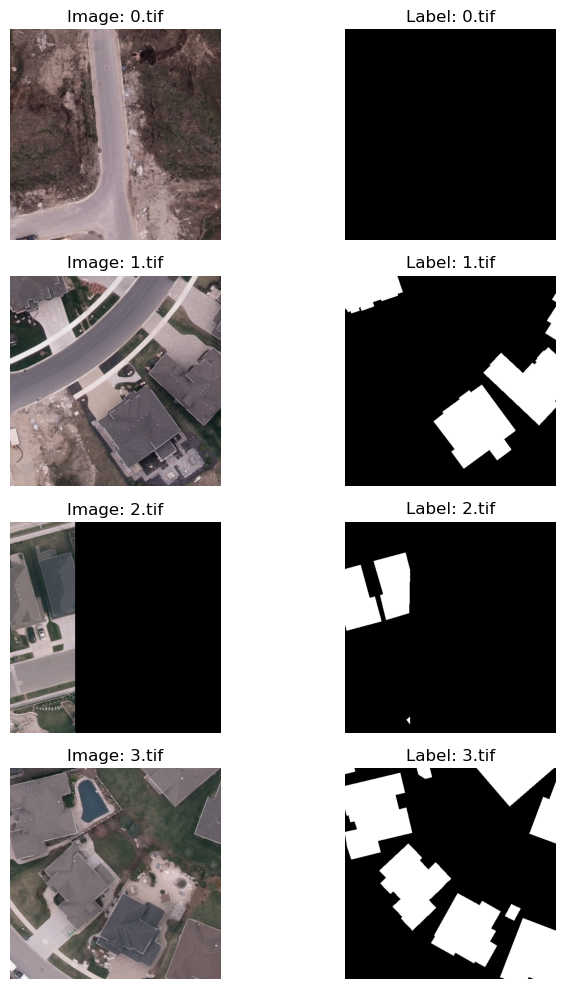

In [6]:
# How many samples to display
num_samples = 4
samples = dm.val_dataset.files[:num_samples]

fig, axes = plt.subplots(num_samples, 2, figsize=(8, 2.5 * num_samples))

for idx, pair in enumerate(samples):
    img_path = pair["image"]
    lbl_path = pair["mask"]

    # Load image
    with rio.open(img_path) as img_ds:
        image_np = img_ds.read().transpose(1, 2, 0).astype(np.float32)
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    # Load label
    with rio.open(lbl_path) as lbl_ds:
        label_np = lbl_ds.read(1)

    # Plot image
    axes[idx, 0].imshow(image_np)
    axes[idx, 0].set_title(f"Image: {img_path.name}")
    axes[idx, 0].axis("off")

    # Plot label
    axes[idx, 1].imshow(label_np, cmap="gray")
    axes[idx, 1].set_title(f"Label: {lbl_path.name}")
    axes[idx, 1].axis("off")

plt.tight_layout()
plt.show()

## Define the UNet++ model

In this step we:

1. Instantiate the `SegmentationUnetPlus` model from `geo_deep_learning/tasks_with_models/segmentation_unetplus.py`
2. Configure the model with:
    - A **ResNet34** encoder (other encoders can be chosen depending on your needs and resources)  
    - **3 input channels** (RGB imagery)
    - **2 output classes** (background vs building) 
    - **SoftCrossEntropyLoss** as the loss function (robust to class imbalance, smooth factor = 0.1)  
    - **Adam** optimizer with a constant learning rate, and a **ReduceLROnPlateau** scheduler  
3. Set a small number of samples to visualize predictions later (`max_samples=4`)
4. Train the model for a few epochs using PyTorch Lightning’s `Trainer` 

> **Note:**  
> In a full workflow, all components (model, loss, optimizer, scheduler, trainer, etc.) would usually be **instantiated automatically by `LightningCLI` via configuration files** (e.g., `configs/unetplus_config_RGB.yaml`).  
> Here, we set them up **manually in the notebook** for clarity in this quickstart.

In [7]:
from geo_deep_learning.tasks_with_models.segmentation_unetplus import SegmentationUnetPlus
from segmentation_models_pytorch.losses import SoftCrossEntropyLoss
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Loss function instance (multi-class, 2 classes: background + buildings)
loss_fn = SoftCrossEntropyLoss(smooth_factor=0.1) 

# Optimizer and scheduler configs
optimizer_class = Adam
optimizer_kwargs = {"lr": 1e-4}

scheduler_class = ReduceLROnPlateau
scheduler_kwargs = {
    "mode": "min",
    "factor": 0.1,
    "patience": 10,
    "cooldown": 1,
    "min_lr": 1e-8,
}

# Model instantiation
model = SegmentationUnetPlus(
    encoder="resnet34",         # backbone encoder
    image_size=(512, 512),
    weights=None,
    in_channels=3,
    max_samples=4,              # visualize up to 4 samples per val epoch
    num_classes=2,
    loss=loss_fn,
    optimizer=lambda params: optimizer_class(params, **optimizer_kwargs),
    scheduler=scheduler_class,
    scheduler_config={
        "interval": "epoch",
        "frequency": 1,
        "monitor": "val_loss"
    },
    class_labels=["background", "buildings"],
    class_colors=["#000000", "#FF0000"],
    weights_from_checkpoint_path=None,
)

/home/lromanin/miniforge3/envs/gdl_env_v09/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.


## Train the UNet++ model

We use PyTorch Lightning’s `Trainer` to launch training:

1. Set up a logger (here we use **MLflow**, but CSV logging is also available)  
2. Define a few training parameters:  
   - run for 10 epochs (adjustable)  
   - run on GPU `(accelerator="gpu")` 
   - track progress with a TQDM progress bar callback  
3. Call `trainer.fit()` with the model and DataModule  

> **Note:** By default, we run on **GPU** (`accelerator="gpu"`), which is much faster. If you don’t have a GPU, you can fall back to **CPU** (`accelerator="cpu"`), but expect training to be significantly slower. 

In [8]:
import pandas as pd
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import MLFlowLogger
from lightning.pytorch.callbacks import TQDMProgressBar

logger = MLFlowLogger(
    experiment_name="unet_segmentation",
    tracking_uri="file:./mlruns"
)

# Define trainer
trainer = Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1,
    precision="32-true",
    callbacks=[TQDMProgressBar()],
    logger=logger,
    log_every_n_steps=1,
)

# Train model
trainer.fit(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/lromanin/miniforge3/envs/gdl_env_v09/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:45: Attribute 'optimizer' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['optimizer'])`.
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type                 | Params | Mode 
----------------------------------------------------------------------
0 | loss                 | SoftCrossEntropyLoss

Sanity Checking: |                                                                                            …

/home/lromanin/miniforge3/envs/gdl_env_v09/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/lromanin/miniforge3/envs/gdl_env_v09/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:369: You have overridden `on_before_batch_transfer` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.
/home/lromanin/miniforge3/envs/gdl_env_v09/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


## Inspect training curves

After training, it’s useful to check that the model is learning as expected.  
Here we fetch the `train_loss` and `val_loss` metrics logged to MLflow and plot them side by side:

- A smooth **downward trend** in both curves indicates proper learning  
- If `val_loss` plateaus or increases while `train_loss` keeps decreasing, it may suggest **overfitting**  
- For this quickstart demo with only a few epochs, expect noisy but generally improving curves

<Axes: >

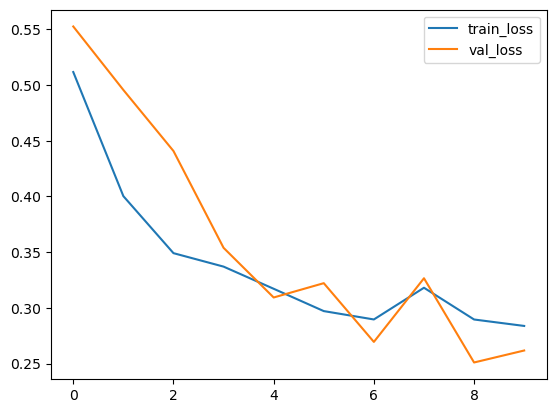

In [9]:
import mlflow

client = mlflow.tracking.MlflowClient()
run_id = logger.run_id

# Fetch metrics
metrics = client.get_metric_history(run_id, "train_loss")
train_loss = [m.value for m in metrics]

metrics = client.get_metric_history(run_id, "val_loss")
val_loss = [m.value for m in metrics]

# Plot with pandas
pd.DataFrame({"train_loss": train_loss, "val_loss": val_loss}).plot()

## Evaluate on the test set

Once training is done, we can evaluate the model on the **held-out test split**.  
This runs the Lightning `test` loop, which uses the `test_dataloader` defined in the DataModule.  

In [10]:
# Run evaluation on the test set (defined by the csv_datamodule)
trainer.test(model, datamodule=dm, ckpt_path=trainer.checkpoint_callback.best_model_path)

Restoring states from the checkpoint path at ./mlruns/406009257167130993/c7dc0307d39346e4ad7d3d45b19dcff8/checkpoints/epoch=9-step=80.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/406009257167130993/c7dc0307d39346e4ad7d3d45b19dcff8/checkpoints/epoch=9-step=80.ckpt
/home/lromanin/miniforge3/envs/gdl_env_v09/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    meaniou_background     │    0.9453754425048828     │
│     meaniou_buildings     │    0.8181524276733398     │
│         test_loss         │    0.2789146900177002     │
└───────────────────────────┴───────────────────────────┘

[{'meaniou_background': 0.9453754425048828,
  'meaniou_buildings': 0.8181524276733398,
  'test_loss': 0.2789146900177002}]

## Visualize prediction artifacts

During testing, the model saved its prediction masks as PNGs in the **MLflow artifacts folder**.  
Here we:

1. Locate the correct experiment/run folder under `mlruns/`  
2. Recursively load the PNG files produced during the test step  
3. Display a few predictions side by side for a quick qualitative check  

> Tip: in your own experiments, you can adjust the number of samples saved during validation/test  
> by changing the `max_samples` parameter when instantiating the model.

Experiment: 406009257167130993 Run: c7dc0307d39346e4ad7d3d45b19dcff8
Artifact dir: mlruns/406009257167130993/c7dc0307d39346e4ad7d3d45b19dcff8/artifacts/test
Found 4 images under mlruns/406009257167130993/c7dc0307d39346e4ad7d3d45b19dcff8/artifacts/test


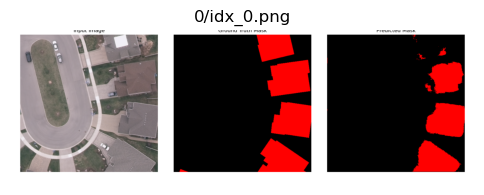

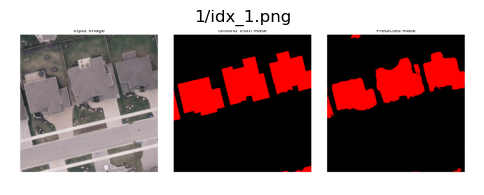

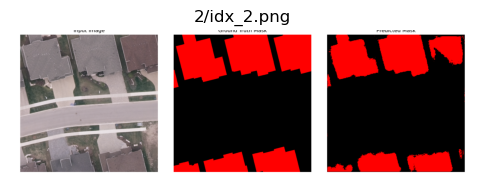

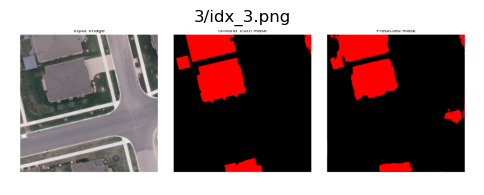

In [11]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# Identify MLflow experiment/run ids
print("Experiment:", logger.experiment_id, "Run:", logger.run_id)
experiment_id = logger.experiment_id
run_id = logger.run_id

# Path to artifacts produced during test loop
artifact_dir = Path("mlruns") / str(experiment_id) / str(run_id) / "artifacts" / "test"
print("Artifact dir:", artifact_dir)

# Find prediction PNGs
img_files = sorted(artifact_dir.rglob("*.png"))
print(f"Found {len(img_files)} images under {artifact_dir}")

# Display first few predictions
for img_file in img_files[:8]:
    img = Image.open(img_file)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(str(img_file.relative_to(artifact_dir)))
    plt.axis("off")
    plt.show()

## Next steps

You’ve completed the **00_quickstart** demo!  
This notebook showed how to:

- prepare data from a simple archive and create CSV splits  
- set up a `CSVDataModule` and `SegmentationUnetPlus` model manually  
- train for a few epochs and inspect learning curves  
- run evaluation and visualize prediction artifacts  

For real projects, you’ll typically want to:

- switch to the **config-driven workflow with `LightningCLI`** (see `01_config_quickstart.ipynb`)  
- train on GPU(s) with larger batch sizes and more epochs  
- customize data preprocessing (tiling, normalization, augmentations)  
- enable checkpoints, early stopping, and richer logging  

Check the `configs/` folder and additional notebooks for more advanced usage.